# Variograms and Kriging

Created by: Derek Robinson <br>
Last Updated: February 19, 2021

### Learning Objectives

In this Jupyter Notebook you will learn or review how to
<ul>
    <li> create a point pattern by importing coordinate data from a text file, </li>
    <li> create a variogram cloud and an experimental variogram, </li>
    <li> plot a variogram surface and understand isotropy versus anisotropy, </li>
    <li> create a gridded sample within a coordinate space,</li>
    <li> conduct interpolation using a Kriging approach,</li>
    <li> create a surface from point data as a raster,</li>
    <li> export a created raster to a geotiff format for use in other software,</li>
    <li> conduct a 10-fold cross validation to evaluate the interpolated surface,</li>
    <li> use a raster overlay to create a difference map between two rasters, </li>
    <li> compare spatial data aspatially using Pearson's and Spearman's Rank correlation coefficient, and</li>
    <li> reclassify ratio data to nominal data using value ranges.
</ul>

### Assignment Completion

For those in GEOG 318/PLAN 353 @UWaterloo, the assignment directions and submission requirements are provided on LEARN as a quiz that spans multiple days. To complete the quiz/assignment you will need to do the following:

<ul>
    <li> Complete this Jupyter Notebook.</li>
    <ul>
        <li> To advance to the next text cell or execute the code in a cell hold <font style="font-family:'Courier New'"><mark font-family="Courier New" style="background-color: #F5F5F5">Shift</mark></font> and press <font style="font-family:'Courier New'"><mark font-family="Courier New" style="background-color: #F5F5F5">Enter</mark></font> </li>
        <li> If there is a method for which you would like to know more about its parameters or how it works then you can place your cursor on the method and press <font style="font-family:'Courier New'"><mark font-family="Courier New" style="background-color: #F5F5F5">Shift + Tab</mark></font> and a help box will appear that you can expand and scroll through.</li>
    </ul>
    <li> Complete the Interpolation Continued Quiz/Assignment in LEARN, which may require you to </li>
    <ul>
        <li> copy results from your notebook into the LEARN input boxes, </li>
        <li> take screen captures of your notebook output and submit them via LEARN, or </li>
        <li> change values in the Jupyter Notebook and re-execute cells/code to obtain new results. </li>
    </ul>
    <li> <b>While you may discuss course content with your classmates, you are to complete the assignment individually.</b></li>
</ul>

### Problem Statement & Data

Unmanned aerial vehicles (UAVs) are becoming a tool for research, government, and commercial use. Given their novelty, contemporary research is benchmarking or comparing UAV generated elevation data against existing elevation data used and acquired by the government, against ground control point data, and other forms of highly accurate data. 

In this assignment you will explore data and spatial autocorrelation using a variogram cloud, variogram, and experimental variogram. You will then generate an interpolated surface, using Kriging, and compare the interpolated surface against an existing digital elevation model.

The study site for this assignment is the northeastern portion of Laurel Creek conservation area in Waterloo, Ontario. The study area was flown in spring of 2015 (leaf-off) with an Flir Systems SkyRanger R60. 

<p style="text-align:center;"><img src="skyranger.png" style="width: 50%;"/></p>

Two flights were conducted for approximately 45 minutes each that acquired 255 visible spectrum images that produced a spatial resolution of 5 cm. Structure-from-motion Multi-view-stereo (SfM MVS) methods were used to derive an orthorectified image and a digital surface model (DSM) of the study area. Using manual interpretation, control points were chosen from this DSM that were known to be located on the ground. 

### Lets get started

Sometimes when running functions and code in R you will receive warnings. These are displayed in pink in Jupyter Notebook following the execution of a cell. The warnings arise for a variety of reasons like a parameter was not specified so a default will be used. In creating these notebooks I have reviewed the warnings and they do not affect the results. The next line of code turns them off so that you are not confused or worried about them. However, if you would like to see them you may restart the notebook and comment the following cell code or skip executing it.

In [ ]:
options(warn=-1)
# command to turn warnings on
# options(warn=0)

In this Notebook, we will use a variety of libraries. The first time you use a library **at home** you have to install it with the `install.packages()` function. After the package is installed you only need to call the `library()` function to gain access to it in a Notebook or R script. In this notebook, the install commands have been commented out using `#` symbols so that the compiler will not interpret the code/text, because they have been installed already on the Jupyter Hub for you. 

In [2]:
#install.packages("sp")
#install.packages("gstat")
#install.packages("gridExtra")
#install.packages("ggplot2")
#install.packages("raster")
#install.packages("rgdal")

library(sp)
library(gstat)
library(gridExtra)
library(ggplot2)
library(scales)
library(raster)
library(rgdal)

In the *Exploring Field Data, Trend Analysis, and Interpolation* Notebook you read in the point pattern of control points using `controlPoints <- readOGR("ControlPoints.shp", "ControlPoints")`, which enabled you to work directly with a shapefile. In this notebook we will read in the data from `.txt` or `.csv` file using the `read.csv()` function. Lets do that now and have a look at the different columns of data within the 

In [3]:
controlPoints <- read.csv(file = 'ControlPts.txt')
colnames(controlPoints)

[1] "OBJECTID" "ON10mDEM" "UAVDSM"   "x"        "y"

We have imported the controlPoints data from a text file. If we view the type of object that the `controlPoints` object we just created is we will see that it is a data.frame(), which has not spatial representation other than our columns of x and y coordinates.

In [35]:
class(controlPoints)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

To work with most spatial functions you have to convert the aspatial data, to some type of spatial dataframe which associates location coordinates with the data. We can formalize our `x` and `y` information in our controlPoints object as coordinates by using the `coordinates()` function.

In [5]:
coordinates(controlPoints)= ~ x+y

Do a quick check with the next code block to confirm that we no longer have a `data.frame`.

In [6]:
class(controlPoints)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

Now that we have a `SpatialPointsDataFrame` object we can use that object for spatial analysis and in this notebook, interpolation.

## Variogram

In this notebook we are going to conduct interpolation. In another notebook we review proximity polygons and inverse distance weighting as methods for interpolation. In this notebook we are going to focus on a method of interpolation called `Kriging`. To perform Kriging we first have to understand and use a variogram cloud. We then fit a model to the variogram cloud to create what is known as an experimental variogram. Then we use the experimental variogram in the Kriging interpolation process.

With the `gstat` library we have access to a `variogram()` function. The function takes in a model, which we will simply specify as the elevation values in our UAVDSM data, the location of our `controlPoints`. The function also allows use to plot the entire cloud of points by setting the `cloud` parameter to TRUE.

Lets create a variogram cloud and then store it in an object names `UAVDSM.vgm.cloud` whereby the vgm will be shorthand for variogram.

In [7]:
UAVDSM.vgm.cloud <- variogram(UAVDSM~1, data=controlPoints, cloud=TRUE)

Now lets plot and visualize the variogram cloud.

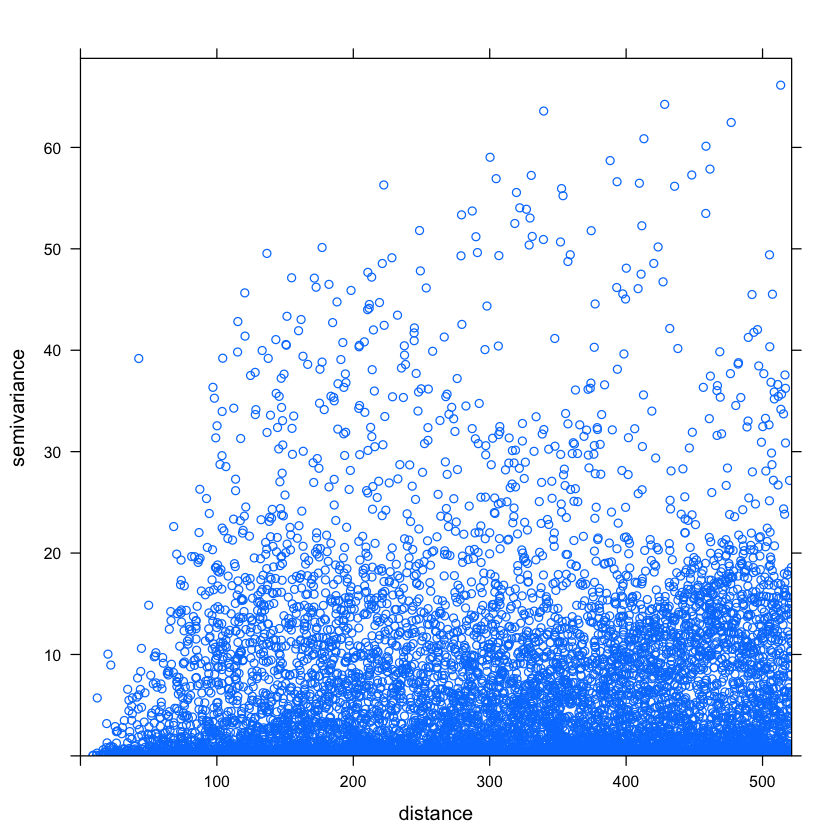

In [8]:
plot(UAVDSM.vgm.cloud)

The variogram cloud works by enumerating through the point pattern such that each point is compared to every other point in the point pattern. Each comparison results in one point in the variogram cloud, whereby the distance between the two points is plotted along the x-axis and the semivariance in their attribute values (in this case elevation) is plotted along the y axis. 

We can compute the number of point-pairs in our data as the number of points `n` multiplied against every other point in the pattern `n - 1` (we minus 1 to exclude the initial point). Since we only need to make the comparison between the two points once, we can devide the result by 2.

Our equation then looks like ${[n (n - 1)] / 2}$


In [9]:
numPts <- length(controlPoints)
paste("The number of point-pair comparisons is", (numPts*(numPts -2))/2)

[1] "The number of point-pair comparisons is 12324"

We can transform the cloud into a variogram by introducting a spatial lag variable. The spatial lag variable represents a distance range within which all the points within that distance range are averaged and plotted as a single point. With the variogram() function, we do not need to specify the number of lags (i.e., how many bins will be used in the variogram), instead the variogram() function will fit in as many lags or bins as possible. 

Lets create a variogram `UAVDSM.vgm` with a 50 m spatial lag using the `width` parameter and set the `cloud` parameter to false.

In [10]:
UAVDSM.vgm <- variogram(UAVDSM~1, data=controlPoints, width=50.0, cloud=FALSE)

Now lets plot our variogram with spatial lag of 50 m.

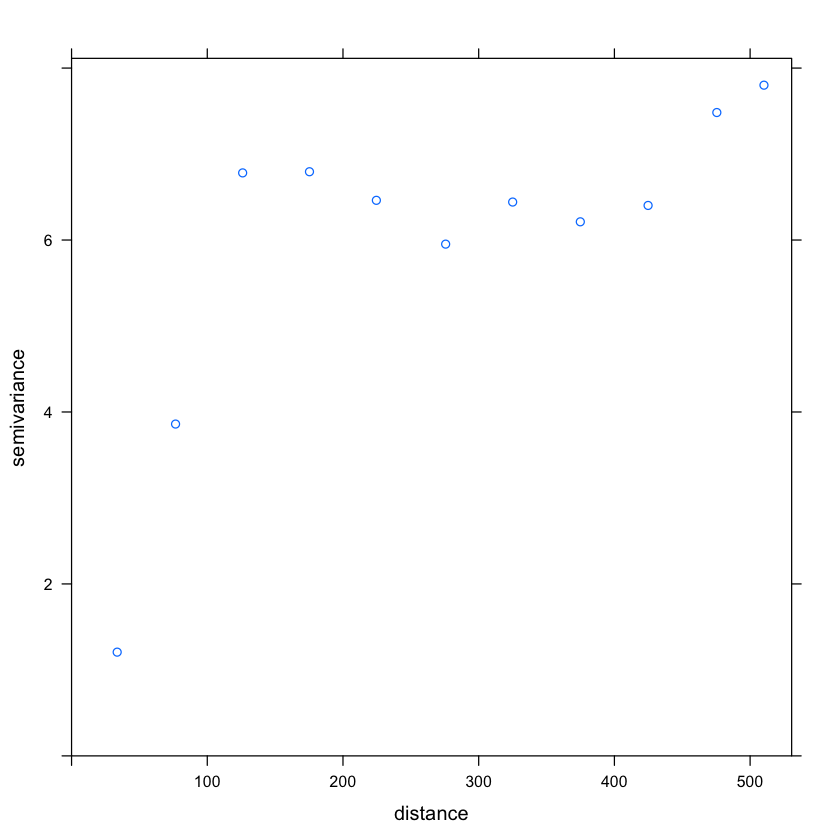

In [11]:
plot(UAVDSM.vgm)

If we `print()` our variogram then we will see a table that is used to generate our plot above. It comprising the number of lags (in the leftmost column) and the number of point pairs `np` in each lag. `dist` is the average distance of all point pairs within the lag and `gamma` is the variogram estimate. `dir.hor` and `dir.ver` are the hortizonal and vertical directions, respectively, and `id` is the combined id pair. We are not concerned about these last three variables here. 

In [12]:
print(UAVDSM.vgm)

     np      dist    gamma dir.hor dir.ver   id
1   204  33.61708 1.206623       0       0 var1
2   510  76.62858 3.859625       0       0 var1
3   720 126.06904 6.780916       0       0 var1
4   833 175.31433 6.794380       0       0 var1
5   897 224.60242 6.461830       0       0 var1
6   893 275.65196 5.952363       0       0 var1
7   982 325.03084 6.441867       0       0 var1
8  1033 374.88190 6.211966       0       0 var1
9  1024 424.82385 6.402261       0       0 var1
10  995 475.47261 7.482971       0       0 var1
11  432 510.20510 7.801135       0       0 var1


Now that we have the variogram we can fit a mathematical model to those points. We will use the mathematical model later as part of the interpolation process. Furthermore, different aspects about the model will tell us useful information about spatial autocorrelation among our controPoints data.

To fit a mathematical model to our variogram we will use the `fit.variogram()` function from `gstat`. We will pass to that function our variogram `UAVDSM.vgm` and inform the function to fit the function to the range of the variogram `fit.ranges = TRUE` and to the sill `fit.sills = TRUE`. We will also tell the `fit.variogram()` function to use a spherical `Sph` mathematical model. 

In [13]:
UAVDSM.vgm.fit <- fit.variogram(UAVDSM.vgm, fit.ranges = TRUE, fit.sills = TRUE, model=vgm("Sph")) 

Now we can can plot the variogram along with the fit model using the following code block.

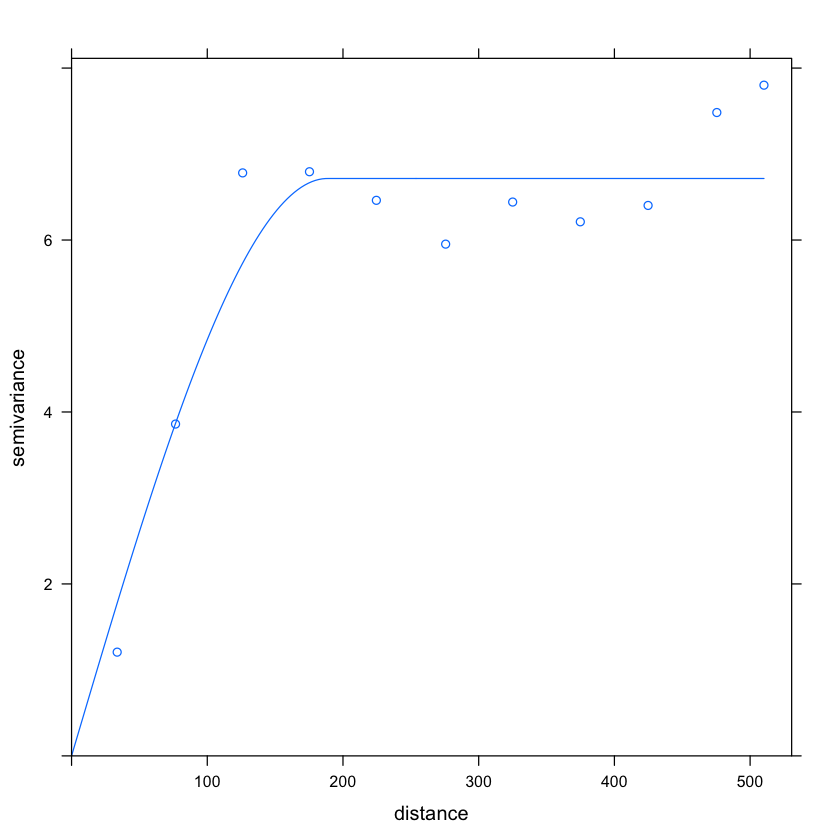

In [14]:
plot(UAVDSM.vgm, UAVDSM.vgm.fit)

If we print out the fitted variogram model then we can see the values of the nugget `Nug`, the partial sill `psill`, and the range `range`.

In [15]:
print(UAVDSM.vgm.fit)

  model    psill    range
1   Nug 0.000000   0.0000
2   Sph 6.715726 188.5685


In the above variogram we fit a spherical model `Sph` to the data. However, there are other models we could fit to the data. Lets have a look at those models.

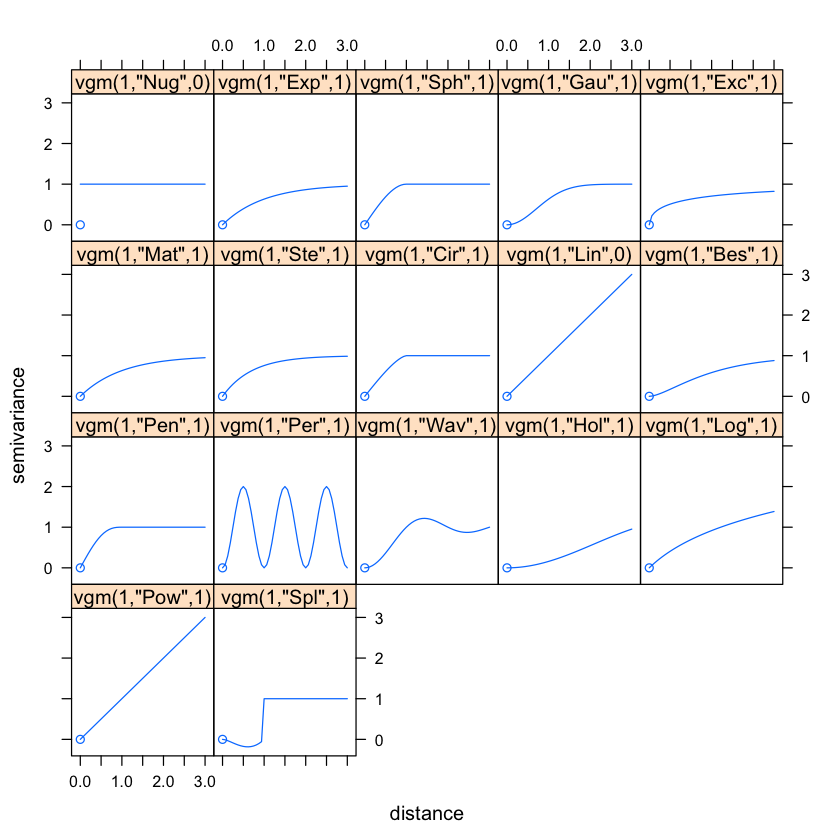

In [16]:
show.vgms()

Recognize that not only would the model name need to change but also the parameters if you wanted to switch the models. 

We can plot the variogram values as a surface or map. The `cutoff` value represents the distance beyond which we will not consider points in our variogram map. The specified value must be a multiple of the spatial lag used and represented by the `width` parameter to acquire a correct symetric variogram map. The variogram map shows similarity and dissimilarity in our control point elevation values and and plots those values in the same direction and sitance relative to the central point of the variogram map. The map and similarities we find within the map can inform us if there is anisotropy (i.e., directional effects) in the spatial autocorrelation of our data.

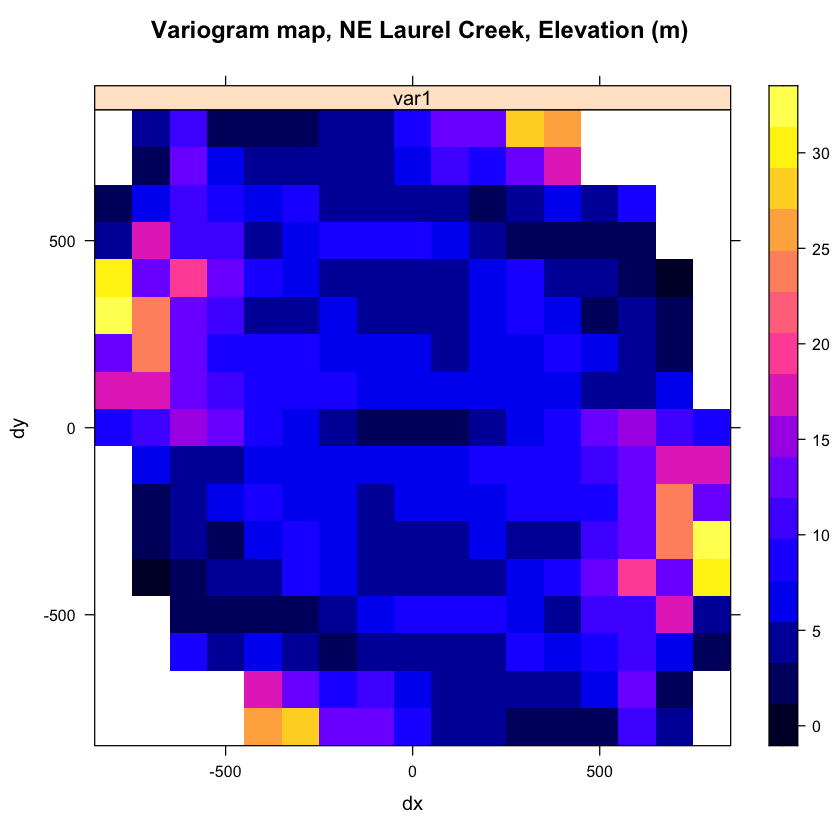

In [17]:
plot(variogram(controlPoints$UAVDSM~ 1, controlPoints, map = TRUE, cutoff = 800, width = 100), main = "Variogram map, NE Laurel Creek, Elevation (m)", col.regions = bpy.colors(64))

In addition to the variogram map, we can subset our elevation points in different directions (e.g., North = 0, East = 90, South = 180, West = 270 ) and see if there are directional effects in the data. To do this use, we can use the `alpha` parameter to specify different angles (bearings) to acquire subsets of our points between those angles. We will break up our points in the northeast, southeast, southwest, and northwest using breaks at the bearings `c(0, 90, 180, 270)`.

In [18]:
UAVDSM.dir = variogram(UAVDSM~1, data=controlPoints, alpha = c(0, 90, 180, 270))

Then we super impose our fitted spherical model for all of the data `UAVDSM.dir.fit` over the directional variograms we just calculated `UAVDSM.dir` to see how well the directional variograms align with our experimental variogram for all the data.

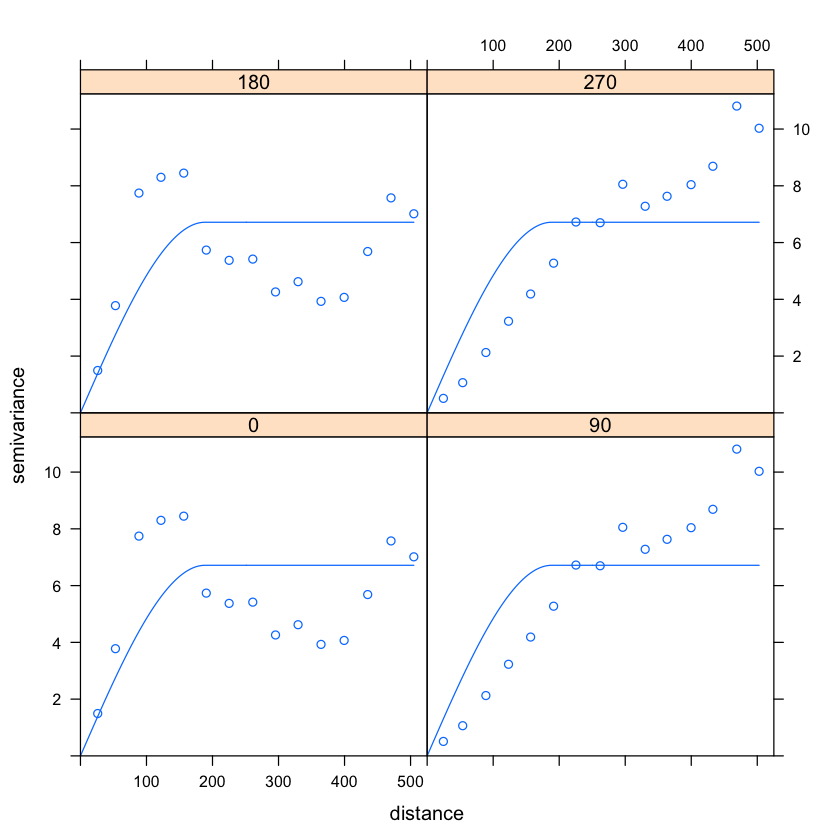

In [19]:
plot(UAVDSM.dir, UAVDSM.vgm.fit)

### Interpolation Using Kriging

Many approaches to interpolation require the delineation of point locations to be interpolated. To generate a grid of point locations for which we want to interpolate elevation values, we need to acquire information from our `controlPoints` data. First we will acquire the spatial extent using the `extent()` function, then create a grid of points with those dimensions. The values `by = 20` are placing points 20 units apart within the range of x and y values. 

In [20]:
extent.cp <- extent(controlPoints)

grid.e <- expand.grid(x = seq(from = round(extent.cp@xmin), to = round(extent.cp@xmax), by = 20),
                      y = seq(from = round(extent.cp@ymin), to = round(extent.cp@ymax), by = 20))

Now lets plot our new grid and see what it looks like

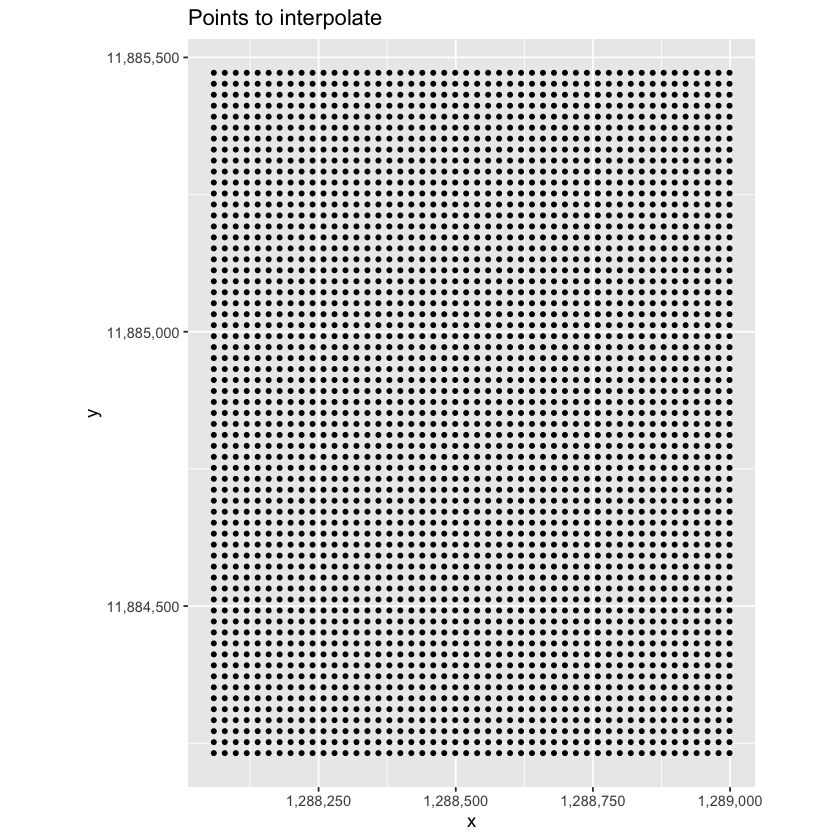

In [21]:
plot2 <- as.data.frame(grid.e)
ggplot(plot2, aes(x, y)) + geom_point(size=1) + coord_equal() + 
   scale_x_continuous(labels = comma) + scale_y_continuous(labels = comma) +
   ggtitle("Points to interpolate")

Lets formalize the gridded point locations as coordinates with the `coordinates()` function. Then ensure the new `grid.e` object has the coorinate reference system used by the controlPoints data by passing it the projection information from the controlPoints data using the `proj4string()` function.

In [22]:
coordinates(grid.e)<- ~x + y
proj4string(grid.e) <- proj4string(controlPoints)

Since we have not plottedd the controlPoints data in this Notebook, lets do that now so we have a visualization of where the points are prior to conducting our interpolation using Kriging. 

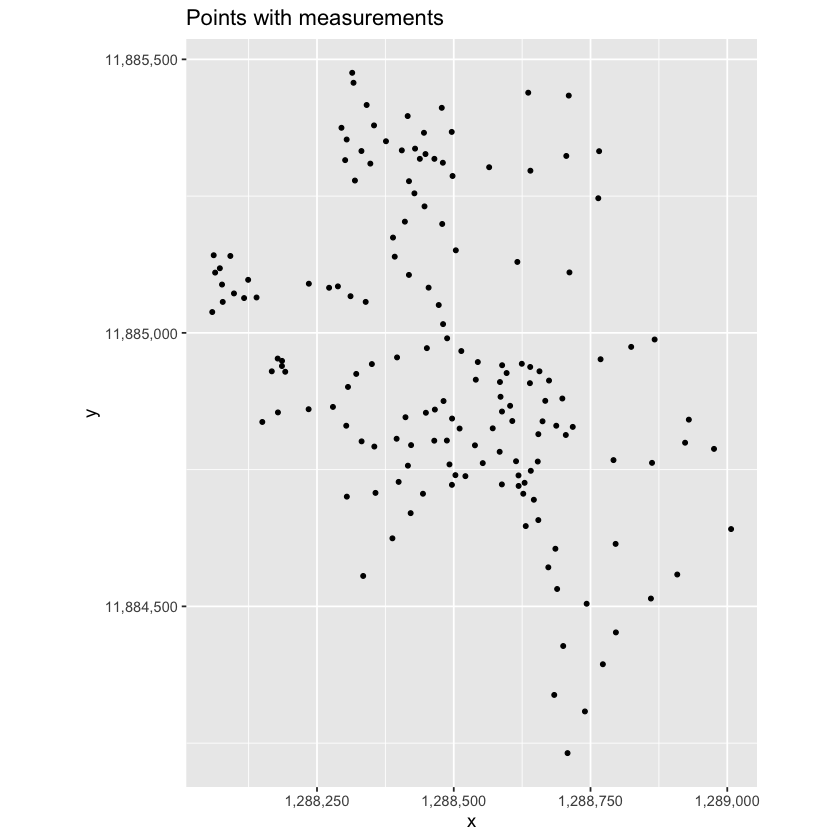

In [23]:
plot1 <- as.data.frame(controlPoints)
ggplot(plot1, aes(x, y)) + geom_point(size=1) + coord_equal() + 
   scale_x_continuous(labels = comma) + scale_y_continuous(labels = comma) +
   ggtitle("Points with measurements")


Now that we have the control points and the locations for which we want to interpolate a value, we can begin the kriging process using ordinary kriging. Create a variable to hold our results and then krige our controlPoints data using the UAVDSM attribute and the variogram model we fit above using the following code:

In [24]:
elev.kriged <- krige(controlPoints$UAVDSM~1, controlPoints, grid.e, model=UAVDSM.vgm.fit)

[using ordinary kriging]


Lets plot our kriged surface and see what it looks like.

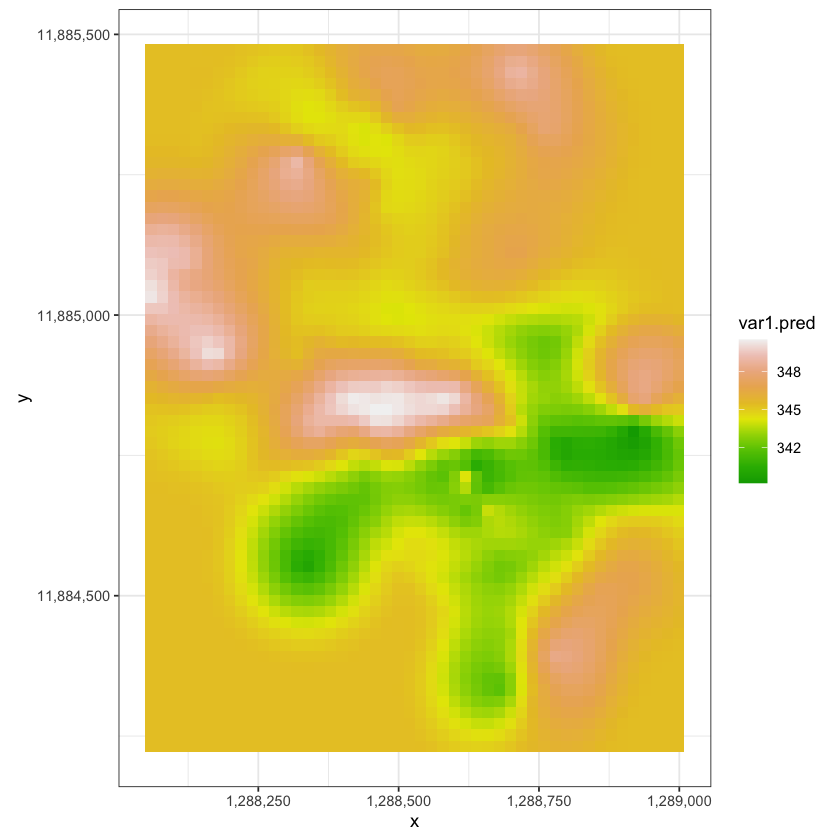

In [25]:
plot3 <- as.data.frame(elev.kriged)
ggplot(plot3,aes(x=x, y=y)) + geom_tile(aes(fill=var1.pred)) + coord_equal() + 
    scale_fill_gradientn(colours = terrain.colors(10)) + scale_x_continuous(labels = comma) + scale_y_continuous(labels = comma) +    
    theme_bw()

At some point you may want to export the data (new interpolated surface) for use in other software. We can do this by converting our interpolated points to a grid using the `gridded()` function, cooerce the interpolated surface into a raster object using `raster()`, and then write the raster out as a geotiff using the `writeRaster()` function.

In [26]:
gridded(elev.kriged) = TRUE
krigedRaster <- raster(elev.kriged)
class(krigedRaster)
writeRaster(krigedRaster, filename = "oRast.tif", "GTiff", overwrite=TRUE)

[1] "RasterLayer"
attr(,"package")
[1] "raster"

Warning message in .gd_SetProject(object, ...):
“NOT UPDATED FOR PROJ >= 6”


To confirm your raster object contains the data lets view it.

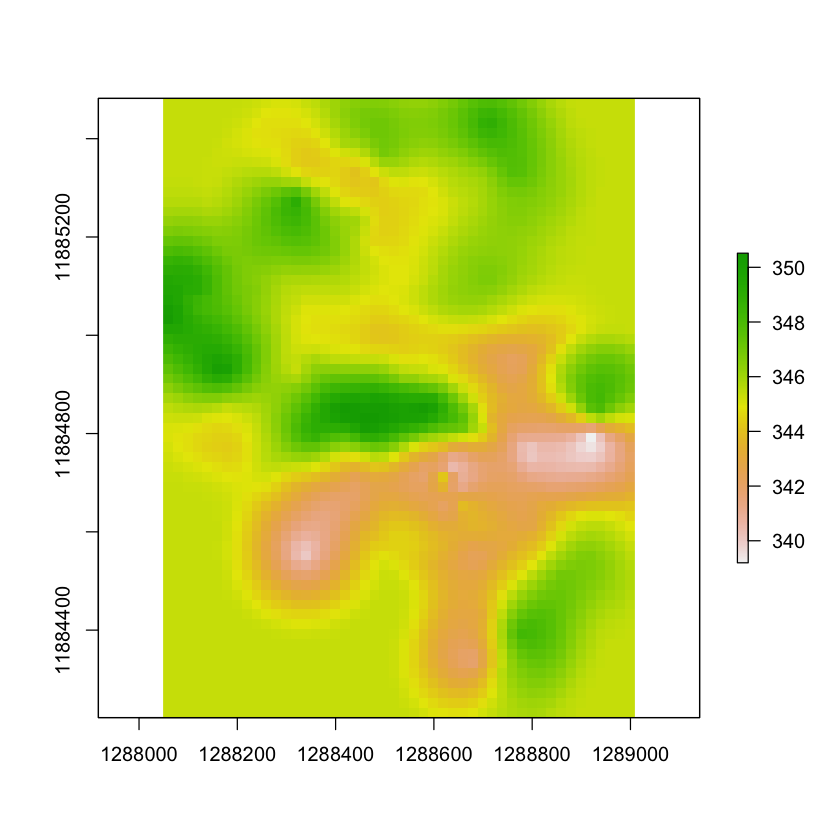

In [27]:
plot(krigedRaster)

We can test the effect that the included number of neighbours have on our interpolated surface by adding and altering the maximum number of neighbours included using the `nmax` parameter. 

In [32]:
elev.kriged <- krige(controlPoints$UAVDSM~1, controlPoints, grid.e, model=UAVDSM.vgm.fit,   nmax=5)

[using ordinary kriging]


And we can view our result with a specified number of maximum neighbours included.

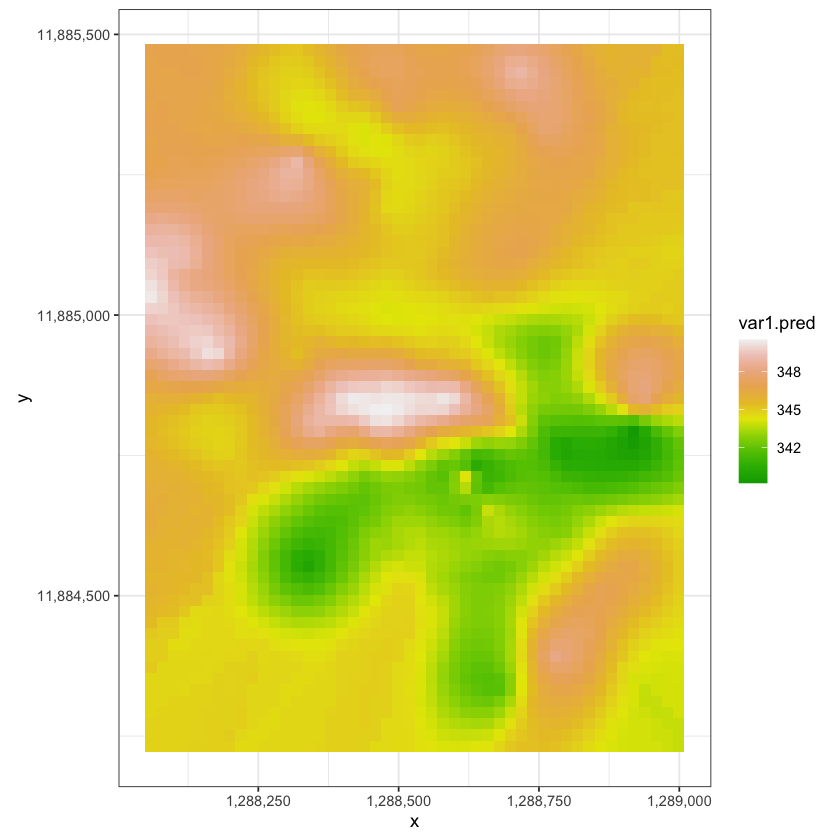

In [33]:
plot4 <- as.data.frame(elev.kriged)
ggplot(plot4,aes(x=x, y=y)) + geom_tile(aes(fill=var1.pred)) + coord_equal() + 
scale_fill_gradientn(colours = terrain.colors(10)) + 
scale_x_continuous(labels = comma) + scale_y_continuous(labels = comma) + theme_bw()

### Cross Validation

To evaluate how well the interpolated (kriged) surface performed we can use cross validation. There are different types of cross validation (e.g., leave one out at a time, or n-fold, among others). The process of cross validation involves taking out some of the control points and comparing their values to the interpolated values. 

As we did above lets create a variogram model, but we will make a simple one for our use here.

In [36]:
m1 = vgm(psill=1, model="Sph", range=900, nugget=1)

Now we can conduct a cross validation of our kriged results using the `krige.cv()` function and passing it the intercept of our UAVDSM data, our controlPoints locations, our locations we want to interpolate values for (i.e., `grid.e`, our variogram model (`m1`), the number of cross validation folds we would like to use `nfold`, and the number of neighbours to include `nmax`. The output is a set of points with additional attributes which we will store in an object called `cv_krige_output`.

In [37]:
cv_krige_output <- krige.cv(UAVDSM~1, controlPoints, grid.e, model=m1, nfold=10, nmax = Inf)

Use the `head()` command to see the format of the data stored in the cv_krige_output object.

In [38]:
head(cv_krige_output)

,var1.pred,var1.var,observed,residual,zscore,fold,x,y
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,346.2061,1.364459,349.0795,2.8733990,2.4598897,4,1288710,11885434
2,346.3637,1.326778,347.1555,0.7918424,0.6874476,8,1288636,11885439
3,346.3948,1.254782,346.1125,-0.2822739,-0.2519919,10,1288706,11885323
4,345.6052,1.209423,344.6592,-0.9459940,-0.8601999,5,1288565,11885303
5,345.9794,1.237032,345.5013,-0.4780829,-0.4298458,2,1288640,11885296
6,346.1503,1.324678,346.6477,0.4974829,0.4322380,5,1288764,11885246


The Kriged output is in a data.frame. Lets convert it to a spatial data.frame by creating spatial coordinates using the x,y location data and then plot the residuals spatially to see where the interpolated surface matches the control points closely (values close to zero) and where it over and under estimates the control point values. 

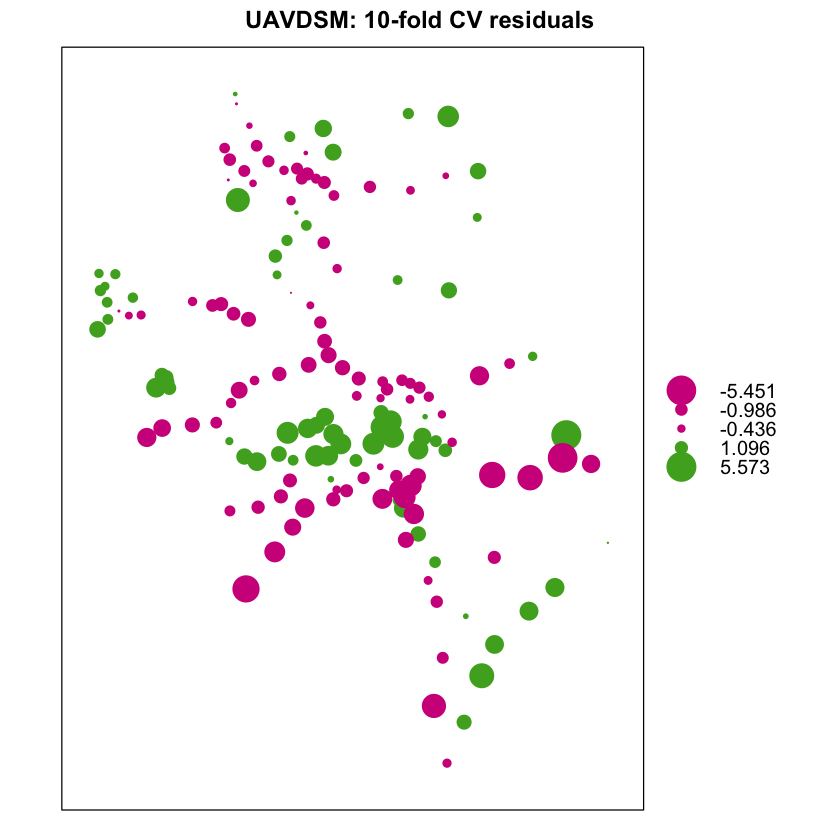

In [39]:
coordinates(cv_krige_output)= ~ x+y
bubble(cv_krige_output, "residual", main = "UAVDSM: 10-fold CV residuals")

We can also **calculate the correlation between the observed and interpolated values** using the `cor()` function, which is an aspatial measure. Remember that correlation does not give us information about accuracy. Lets compute both Pearson's correlation coefficient and Spearman's Rank correlation coefficient.

In [40]:
cor(cv_krige_output$observed, cv_krige_output$var1.pred, method = "pearson")

[1] 0.7654709

In [41]:
cor(cv_krige_output$observed, cv_krige_output$var1.pred, method = "spearman")

[1] 0.7765696

### Raster Comparison

The last step of this Notebook involves comparing our kriged results to the ON10mDEM. Load the Ontario DEM as a raster object and plot it.

In [ ]:
ON10mDEM <- raster("ON10mDEM.tif")
plot(ON10mDEM)

If you plot the krigedRaster again you will see that it has a different size and extent. 

In [ ]:
plot(krigedRaster)

We can view the differences in spatial extent by using the `extent()` function on each raster.

In [ ]:
extent(ON10mDEM)
extent(krigedRaster)

However, if we want to compare the two layers then they have to have the same spatial extent and resolution. We can achieve both processes in one step by resampling the Ontario DEM data to match that of our kriged raster by using the `resample()` function.

In [ ]:
resampled_ON10mDEM <- resample(ON10mDEM, krigedRaster, method="bilinear")

Plot the resampled Ontario dem to make sure it worked and to visualise your results.

In [ ]:
plot(resampled_ON10mDEM)

One way to compare the two elevation surfaces is to do a simple differencing of values by subtracting the kriged surface from the Ontario DEM and plot it to see the difference.

In [ ]:
ON10mDEM_subtract_krigedRaster <- overlay(resampled_ON10mDEM, krigedRaster, fun=function(r1, 
    r2){return(r1-r2)})
plot(ON10mDEM_subtract_krigedRaster, col = heat.colors(10))

We can use the `reclassify()` function to classify the difference raster we just created to see where the two rasters are similar and where the kriged interpolation over and under predicts elevation relative to the Ontario DEM. First we have to create a list of break values that will define the range for each class.

In [ ]:
reclassifyRanges <- c(-Inf, -1, -1,  -0.99, 0.99, 0,  1, Inf, 1)

Then we will place these ranges in a matrix format using the `matrix()` function since this format is required by the raster reclassify function.

In [ ]:
reclassifyMatrix <- matrix(reclassifyRanges, ncol=3, byrow=TRUE)

To be sure we understand how the ranges are defined and that they are represented appropriately in the matrix, lets view the reclassifyMatrix

In [ ]:
reclassifyMatrix

Now we can reclassify our difference raster into three class (over estimated, approximately equal, and under estimated) and plot the results.

In [ ]:
reclassifiedDifferences <- reclassify(ON10mDEM_subtract_krigedRaster, reclassifyMatrix)
   plot(reclassifiedDifferences)

# Congratulations!

**You have reached the end of the Variograms and Kriging notebook**